Copying files: 16132 files [00:07, 2179.56 files/s]


Found 12898 images belonging to 17 classes.
Found 1629 images belonging to 17 classes.
Found 1605 images belonging to 17 classes.


Epoch 1/2


2023-06-21 11:38:59.072034: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


516/516 [==============================] - ETA: 0s - loss: 1.2807 - accuracy: 0.7036

2023-06-21 12:14:37.781928: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


516/516 [==============================] - 2208s 4s/step - loss: 1.2807 - accuracy: 0.7036 - val_loss: 0.4355 - val_accuracy: 0.8623
Epoch 2/2
1/1 [==============================] - 0s 409ms/step
입력된 mel-spectrogram은 피아노연주소리 소리와 97.79865145683289 % 비슷합니다.


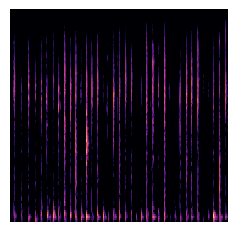

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [1]:
import librosa
import librosa.display
from PIL import Image
import splitfolders
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten, Dense, Dropout, Input  # Input 모듈 추가
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# 음성 파일 경로
wav_file_path = '/Users/gim-yeongmin/Downloads/아이들발소리.wav'

# 음성 파일 로드
waveform, sample_rate = librosa.load(wav_file_path, sr=None)

# Mel-spectrogram 계산
mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)

# 로그 스케일로 변환
log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)

# Mel-spectrogram 시각화
plt.figure(figsize=(12, 6))
librosa.display.specshow(log_mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.axis('off')  # 축 제거
plt.tight_layout()

# 이미지 크기 조정
plt.gcf().set_size_inches(2.24, 2.24)  # 인치 단위로 크기 조정 (224x224 -> 2.24x2.24)

# 이미지 저장
resized_image = plt.gcf()
resized_image.savefig('mel_spectrogram_resized1.png', dpi=100)  # dpi를 조정하여 해상도 조절

# 이미지 출력
resized_image.show()

# 이미지 분할
splitfolders.ratio('/Users/gim-yeongmin/Downloads/사업/데이터/Spectrogram',
                   output='/Users/gim-yeongmin/Downloads/사업/데이터/Spectrogram', seed=1337, ratio=(0.8, 0.1, 0.1))

# 경로 설정
train_path = '/Users/gim-yeongmin/Downloads/사업/데이터/Spectrogram/train'
test_path = '/Users/gim-yeongmin/Downloads/사업/데이터/Spectrogram/test'
val_path = '/Users/gim-yeongmin/Downloads/사업/데이터/Spectrogram/val'

# 데이터 로더 생성
batch_size = 25
test_batch_size = 32
test_steps = 1

trgen = ImageDataGenerator(horizontal_flip=True)
tvgen = ImageDataGenerator()

train_generator = trgen.flow_from_directory(directory=train_path, target_size=(224, 224), class_mode='categorical',
                                            color_mode='rgb', shuffle=True, batch_size=batch_size)
test_generator = tvgen.flow_from_directory(directory=test_path, target_size=(224, 224), class_mode='categorical',
                                           color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_generator = tvgen.flow_from_directory(directory=val_path, target_size=(224, 224), class_mode='categorical',
                                            color_mode='rgb', shuffle=True, batch_size=batch_size)

# 입력 이미지의 크기
input_shape = (224, 224, 3)

# 입력 레이어 정의
image_input = Input(shape=input_shape)

# 이미지 전처리 함수 적용
preprocessed_input = tf.keras.applications.resnet.preprocess_input(image_input)

# ResNet50 모델 불러오기 (include_top=False로 설정하여 fully connected layer를 제외)
resnet_model = ResNet50(input_tensor=preprocessed_input, weights='imagenet', include_top=False)

# Flatten 레이어 추가
flatten = Flatten()(resnet_model.output)

# Fully Connected 레이어 추가
dense = Dense(256, activation='relu')(flatten)
output = Dense(17, activation='softmax')(dense)

# 새로운 모델 구성
model = Model(inputs=resnet_model.input, outputs=output)

# 새로운 모델 컴파일
learn_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 학습
epochs = 2
history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, verbose=1)
model.save("my_model1.h5")

# 모델 불러오기
model_path = '/Users/gim-yeongmin/Downloads/my_model1.h5'
model = load_model(model_path)

# 이미지 경로
new_image_path = '/Users/gim-yeongmin/Downloads/mel_spectrogram_resized.png'

# 이미지 불러오기
new_image = image.load_img(new_image_path, target_size=(224, 224))
new_image = image.img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)
new_image = tf.keras.applications.resnet.preprocess_input(new_image)

# 예측 수행
predictions = model.predict(new_image)
predicted_class_index = np.argmax(predictions)
predicted_class = list(train_generator.class_indices.keys())[predicted_class_index]
prediction_percentage = predictions[0][predicted_class_index] * 100

# 폴더 삭제 함수 정의
def delete_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"폴더 {path}가 삭제되었습니다.")
    else:
        print(f"폴더 {path}가 존재하지 않습니다.")

# 폴더 삭제 실행
delete_folder(train_path)
delete_folder(test_path)
delete_folder(val_path)

# 결과 출력
print("입력된 mel-spectrogram은", predicted_class, "소리와", prediction_percentage, "% 비슷합니다.")
